In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=VH2OIPC5NKDGRNFJ9LW5W2KSU3YP4T
%env CLEARML_API_SECRET_KEY=Ixtz1NVs8wKDzNfyakkHIHHWN_Oy4vuzwbza8gu2za5SZpcl62e3s6v3s7uN9SzKbII

In [ ]:
from clearml import Task

task = Task.init(project_name="Rosneft segmentation", task_name="Experiment 3")

In [6]:
# api {
#   # Daniel Matveev's workspace
#   web_server: https://app.clear.ml/
#   api_server: https://api.clear.ml
#   files_server: https://files.clear.ml
#   credentials {
#     "access_key" = "VH2OIPC5NKDGRNFJ9LW5W2KSU3YP4T"
#     "secret_key" = "Ixtz1NVs8wKDzNfyakkHIHHWN_Oy4vuzwbza8gu2za5SZpcl62e3s6v3s7uN9SzKbII"
#   }
# }

In [3]:
import torch
import gc
import os

In [2]:

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

clear_gpu_memory()


In [4]:
import os
import sys

import cv2
import random
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import SamModel, SamProcessor
from peft import get_peft_model, LoraConfig, TaskType


sys.path.append(os.path.abspath('/home/dmatveev/workdir/rosneft_segmentation/experiments'))

from prepare_data import SegmentationDataset, SeismicDataset

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_config = {
    "model": {
        "pretrained": "facebook/sam-vit-huge", 
        "use_lora": True,
        "lora_config": { 
            "r": 64,
            "lora_alpha": 64,
            "target_modules": ["q_proj", "k_proj", "v_proj", "out_proj"],
            "lora_dropout": 0.1,
            "bias": "none",
            "task_type": "FEATURE_EXTRACTION"
        },
        "freeze_base": True
    },
    "training": {
        "epochs": 2,
        "batch_size": 4,
        "lr": 1e-4,
        "num_workers": 2,
        "log_interval": 10,
        "use_mask": True 
    },
    "data": {
        "type": "2D",
        "seismic_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d/seismic",
        "label_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d/label",
        "shape": (224, 224),
        "mask_dtype": np.uint8
    },
    "clearml": {
        "project_name": "SAM Fine Tuning",
        "task_name": "LoRA Training"
    }
}

# task.connect(train_config)

In [6]:
data_cfg = train_config["data"]

dataset = SegmentationDataset({
    "type": data_cfg.get("type", "2D"),
    "seismic_dir": data_cfg["seismic_dir"],
    "label_dir": data_cfg["label_dir"],
    "shape": data_cfg["shape"],
    "mask_dtype": data_cfg.get("mask_dtype", 0),
    "use_pil": True
})

In [7]:
def custom_collate(batch):
    return {
        "filename": [item[0] for item in batch],
        "seismic_img": [item[1] for item in batch],
        "label": [item[2] for item in batch]
    }

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=custom_collate)

In [9]:
# zero_count = 0

# for filename, pil_image, label in tqdm(train_dataset):
#     if np.all(label == 0):
#         zero_count += 1

# print("Количество изображений, маска которых состоит полностью из 0:", zero_count)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SamModel.from_pretrained(train_config["model"]["pretrained"]).to(device)
processor = SamProcessor.from_pretrained(train_config["model"]["pretrained"])

In [11]:
if train_config["model"]["freeze_base"]:
    for param in model.parameters():
        param.requires_grad = False

In [12]:
if train_config["model"]["use_lora"]:
    lora_cfg = train_config["model"]["lora_config"]
    lora_config = LoraConfig(
        r=lora_cfg["r"],
        lora_alpha=lora_cfg["lora_alpha"],
        target_modules=lora_cfg["target_modules"],
        lora_dropout=lora_cfg["lora_dropout"],
        bias=lora_cfg["bias"],
        task_type=TaskType.FEATURE_EXTRACTION
    )
    model = get_peft_model(model, lora_config)

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 753664


In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config["training"]["lr"])
num_epochs = 1
# num_epochs = train_config["training"]["epochs"]
log_interval = train_config["training"]["log_interval"]

In [14]:
for batch_idx, batch in enumerate(train_loader):
    break

In [17]:
batch["label"][0]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], shape=(224, 224), dtype=float32)

In [16]:
labels = torch.stack([torch.tensor(lbl) for lbl in batch["label"]]).to(device)

batch_input_points = []
for label in labels.cpu().numpy():
    h, w = label.shape
    nonzero_indices = np.argwhere(label == 1)
    if len(nonzero_indices) > 0:
        idx = random.randint(0, len(nonzero_indices) - 1)
        y, x = nonzero_indices[idx]
        prompt_point = [[x, y]]
    else:
        prompt_point = [[w / 2.0, h / 2.0]]
    batch_input_points.append(prompt_point)

In [18]:
inputs = processor(batch["seismic_img"], input_points=batch_input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [56]:
inputs["pixel_values"].shape

torch.Size([4, 3, 1024, 1024])

In [19]:
outputs = model(**inputs)

In [22]:
outputs.pred_masks.shape

torch.Size([4, 1, 3, 256, 256])

In [23]:
pred_logits = outputs.pred_masks[:, 0, 1, :, :]  # Результат имеет форму [B, 256, 256]


In [27]:
pred_logits[0]

tensor([[ 2.9518,  4.2566,  4.0046,  ..., -3.2916, -3.5183, -3.2439],
        [ 3.4410,  5.3483,  5.1840,  ..., -2.5229, -2.1467, -1.9390],
        [ 4.2161,  7.2760,  7.3449,  ..., -3.3947, -3.6412, -3.6740],
        ...,
        [ 4.1497,  5.5169,  5.2447,  ..., -2.2892, -2.1196, -2.5065],
        [ 3.5271,  5.7272,  5.2027,  ..., -2.1220, -2.1811, -2.6361],
        [ 3.2823,  4.1460,  4.2626,  ..., -2.4162, -2.3210, -2.3513]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [28]:
pred_probs = torch.sigmoid(pred_logits[0])
# Применяем порог, чтобы получить бинарную маску
pred_mask = (pred_probs > 0.5).float()

In [32]:
# Получаем post-processed маску (предположим, что она уже имеет нужный размер)
processed_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

# Из postprocessed результата извлекаем нужный канал, например:
processed_mask = processed_masks[0][0][1, :, :]

# Сравнение с нашим ручным вариантом
manual_mask = pred_mask.cpu().numpy()

print("Ручная маска:", manual_mask)
print("Postprocessed маска:", processed_mask.numpy())


Ручная маска: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
Postprocessed маска: [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [31]:
pred_mask.shape

torch.Size([256, 256])

In [59]:
masks = processor.image_processor.post_process_masks(
                outputs.pred_masks.cpu(),
                inputs["original_sizes"].cpu(),
                inputs["reshaped_input_sizes"].cpu()
            )

In [62]:
for mask in masks:
    pred_logit = mask[0][1, :, :]  # [H, W]
    break

In [64]:
pred_logit.shape

torch.Size([224, 224])

: 

In [61]:
len(masks)

4

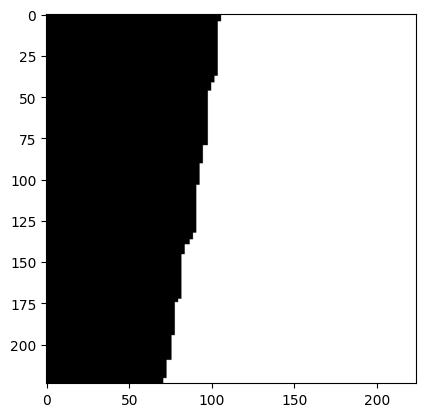

In [17]:
plt.imshow(batch["label"][1], cmap='gray')
plt.show()

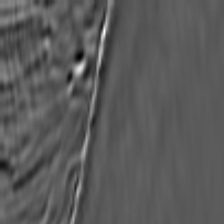

In [18]:
batch["seismic_img"][1]

In [40]:
input_points = [[[100, 100]]]
inputs = processor(batch["seismic_img"][1], input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)

# processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [41]:
mask = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [42]:
mask[0][0][0,:,:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

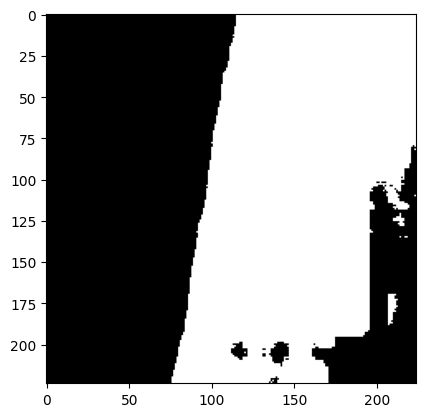

In [46]:

plt.imshow(mask[0][0][1,:,:], cmap='gray')
plt.show()

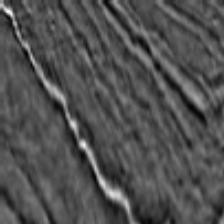

In [15]:
batch["seismic_img"][0]

In [ ]:
epoch_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100)
    
    for batch_idx, batch in enumerate(pbar):
        optimizer.zero_grad()

        inputs = processor(batch["seismic_img"], return_tensors="pt")
        seismic_imgs = inputs["pixel_values"].to(device)
        
        # Convert labels to tensors
        labels = torch.tensor(batch["label"]).to(device)

        image_embeddings = model.get_image_embeddings(seismic_imgs)

        batch_prompts = []
        for label in labels.cpu().numpy():
            h, w = label.shape
            nonzero_indices = np.argwhere(label != 0)
            if len(nonzero_indices) > 0:
                idx = random.randint(0, len(nonzero_indices) - 1)
                y, x = nonzero_indices[idx]
                prompt_point = [[x, y]]
            else:
                prompt_point = [[w / 2.0, h / 2.0]]
            batch_prompts.append(prompt_point)

        prompt_inputs = processor(batch["seismic_img"], input_points=batch_prompts, return_tensors="pt")
        prompt_inputs = {k: v.to(device) for k, v in prompt_inputs.items()}
        prompt_inputs.pop("pixel_values", None) 
        prompt_inputs.update({"image_embeddings": image_embeddings})

        outputs = model(**prompt_inputs)
        pred_masks = outputs.pred_masks

        if pred_masks.ndim == 5:
            pred_logits, _ = pred_masks.max(dim=2)  # [B, 1, H, W]
            pred_logits = pred_logits.squeeze(1)
        elif pred_masks.ndim == 4:
            pred_logits, _ = pred_masks.max(dim=1)  # [B, H, W]
        elif pred_masks.ndim == 3:
            pred_logits, _ = pred_masks.max(dim=0)  # [H, W]
            pred_logits = pred_logits.unsqueeze(0)  # [1, H, W]
        else:
            raise ValueError(f"Unexpected pred_masks shape: {pred_masks.shape}")

        # Ensure prediction size matches the ground truth.
        if pred_logits.shape[-2:] != labels.shape[-2:]:
            pred_logits = F.interpolate(pred_logits.unsqueeze(1),
                                        size=labels.shape[-2:],
                                        mode="bilinear",
                                        align_corners=False).squeeze(1)

        loss = F.binary_cross_entropy_with_logits(pred_logits, labels.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        current_iter = epoch * len(train_loader) + batch_idx
        if batch_idx % log_interval == 0:
            loss_value = loss.item()
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss_value:.4f}")
            task.get_logger().report_scalar(title="Loss", series="train_batch", value=loss_value, iteration=current_iter)
    
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
    task.get_logger().report_scalar(title="Loss", series="train_epoch", value=avg_loss, iteration=epoch+1)
    
    # Generate and report a plot of loss evolution for this epoch
    plt.figure()
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    # Save plot locally
    loss_plot_path = f"loss_plot_epoch_{epoch+1}.png"
    plt.savefig(loss_plot_path)
    plt.close()
    task.get_logger().report_image(title="Loss Plot", series="train", local_path=loss_plot_path, iteration=epoch+1)
    
    # Save checkpoint artifact
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pt"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss,
    }, checkpoint_path)
    task.upload_artifact(name=f"checkpoint_epoch_{epoch+1}", artifact_object=checkpoint_path)

# test

In [8]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def to_pil_image(np_img):
    if np_img.dtype != np.uint8:
        if np_img.max() != np_img.min():
            np_img = (255 * (np_img - np_img.min()) / (np_img.max() - np_img.min())).astype(np.uint8)
        else:
            np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)

def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [2]:
dataset_path_test_temp = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir_test_temp = os.path.join(dataset_path_test_temp, "seismic")
label_dir_test_temp   = os.path.join(dataset_path_test_temp, "label")
all_files_test_temp = sorted(os.listdir(seismic_dir_test_temp))
val_files_test_temp = all_files_test_temp[:10]

NameError: name 'os' is not defined

In [10]:
def display_four_images(image, gt_mask, pred_mask, threshold=0.5):
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()
    
    pos_indices = np.argwhere(gt_mask > threshold)
    if len(pos_indices) == 0:
        h, w = gt_mask.shape
        point = [h // 2, w // 2]
    else:
        point = random.choice(pos_indices)  # (row, col)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Исходное изображение
    axes[0].imshow(img_np)
    axes[0].set_title("Исходное")
    axes[0].axis("off")
    
    # 2. Исходное изображение с отмеченной точкой
    axes[1].imshow(img_np)
    axes[1].scatter(point[1], point[0], color="green", marker="o", s=100)
    axes[1].set_title("С точкой (ground truth)")
    axes[1].axis("off")
    
    # 3. Ground truth маска
    axes[2].imshow(gt_mask, cmap="gray")
    axes[2].set_title("Ground Truth Маска")
    axes[2].axis("off")
    
    # 4. Предсказанная маска
    axes[3].imshow(pred_mask, cmap="gray")
    axes[3].set_title("Предсказанная Маска")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()


In [1]:
ious = []
dices = []

for filename in val_files_test_temp:
    seismic_path = os.path.join(seismic_dir_test_temp, filename)
    label_path   = os.path.join(label_dir_test_temp, filename)

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    pil_image = to_pil_image(seismic_img).convert("RGB")

    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        chosen_idx = random.choice(pos_indices)
        prompt_point = [[float(chosen_idx[1]), float(chosen_idx[0])]]
    else:
        h, w = label.shape
        prompt_point = [[w / 2.0, h / 2.0]]
    input_points = [prompt_point]

    inputs = processor(pil_image, input_points=input_points, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )
    pred_mask = masks[0][0].cpu().numpy()
    pred_mask = masks[0][0][1,:,:]
    pred_mask = pred_mask.cpu().numpy()

    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)
    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    display_four_images(pil_image, label, pred_mask)

NameError: name 'val_files_test_temp' is not defined

In [24]:
sum(dices)/len(dices)

np.float64(0.5388067461453254)